# Generate Rotation Data

## Load patients' ROI data

In [17]:
import time

ROI_CT_path = '../Resources/ROI_CT.xlsx'
ROI_MR_path = '../Resources/ROI_MR.xlsx'

In [18]:
import pandas as pd

roi_CT = pd.read_excel(ROI_CT_path, index_col=[0, 1], header=[0, 1])
print(roi_CT)

              Bridget           Chris           Jean-Marc           Median  \
                    X    Y    Z     X    Y    Z         X    Y    Z      X   
AH LLSCC ant      758  449  207   758  449  207       757  448  207    758   
   LLSCC post     751  478  205   751  478  205       751  479  207    751   
   RLSCC ant      243  475  214   243  475  214       243  473  214    243   
   RLSCC post     256  502  208   256  502  208       256  501  209    256   
AZ LLSCC ant      797  524  247   797  524  247       795  524  246    797   
...               ...  ...  ...   ...  ...  ...       ...  ...  ...    ...   
PH RLSCC post     235  512  216   235  512  216       236  511  217    235   
SM LLSCC ant      771  564  209   771  564  209       769  562  210    771   
   LLSCC post     754  584  199   754  584  199       753  582  199    754   
   RLSCC ant      233  524  256   233  524  256       235  523  255    233   
   RLSCC post     248  544  239   248  544  239       248  544  

In [19]:
import numpy as np

AH_pts = np.copy(roi_CT.loc['AH'].Median.loc[['LLSCC ant', 'LLSCC post', 'RLSCC ant', 'RLSCC post']].values)

In [20]:
pname_list = list(set([x for (x, y) in roi_CT.index]))
print(pname_list)

['LP', 'DE', 'SM', 'LG', 'GE', 'HH', 'AZ', 'DM2', 'PH', 'DGL', 'GM', 'MJ', 'FA', 'JM', 'JH', 'GP', 'NV', 'DM', 'AH', 'HB']


## Load patients' DICOM data: CT/MR

In [21]:
import pydicom as dicom
import os
import numpy

def load_dicom_data(p_name, dicom_path):

    lst_files_dcm = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(dicom_path):
        for filename in fileList:
            if filename[0:2] == '._':
                continue
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lst_files_dcm.append(os.path.join(dirName,filename))

    # Get ref file
    ref_ds = dicom.read_file(lst_files_dcm[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    const_pixel_dims = (int(ref_ds.Rows), int(ref_ds.Columns), len(lst_files_dcm))
    # Load spacing values (in mm)
    const_pixel_spacing = (float(ref_ds.PixelSpacing[0]), float(ref_ds.PixelSpacing[1]), float(ref_ds.SliceThickness))

    # The array is sized based on 'ConstPixelDims'
    array_dicom = numpy.zeros(const_pixel_dims, dtype=ref_ds.pixel_array.dtype)
    # loop through all the DICOM files
    for filenameDCM in lst_files_dcm:
        # read the file
        ds = dicom.read_file(filenameDCM, force=True)
        # For error: "'FileMetaDataset' object has no attribute 'TransferSyntaxUID'"
        #if "TransferSyntaxUID" not in ds.file_meta:
            #ds.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian
        #    print(filenameDCM)
        #    continue
        #if 'Image Storage' not in ds.SOPClassUID.name:
        #    continue  # to skip the rest of the loop
        # store the raw image data
        array_dicom[:, :, lst_files_dcm.index(filenameDCM)] = ds.pixel_array

    return array_dicom, const_pixel_spacing, ref_ds

In [22]:
dicom_AH_CT_path = '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post/AH Pre'

AH_volume, AH_pixel_space, AH_dicom_ref = load_dicom_data("AH", dicom_AH_CT_path)

### Present ROI and DICOM

In [23]:
from matplotlib import pyplot
from matplotlib.patches import Circle

def show_pts(volume, pts, pixel_space):
    y_row = numpy.arange(0.0, volume.shape[0]*pixel_space[0], pixel_space[0])
    x_column = numpy.arange(0.0, volume.shape[1]*pixel_space[1], pixel_space[1])
    z_slice = numpy.arange(0.0, volume.shape[2]*pixel_space[2], pixel_space[2])

    landmark_radius = volume.shape[1]*pixel_space[1] * 0.016

    fig, axs = pyplot.subplots(2,2,sharex=True)
    fig.set_dpi(300)

    axs[0][0].set_title("LLSCC ant")
    axs[0][0].set_aspect('equal', 'datalim')
    axs[0][0].pcolormesh(x_column[:], y_row[:], volume[:, :, pts[0, 2]], cmap=pyplot.gray())
    LLSCC_ant = Circle((pts[0, 0]*pixel_space[1], pts[0, 1]*pixel_space[0]), landmark_radius, facecolor='None', edgecolor='r', lw=1)
    axs[0][0].add_patch(LLSCC_ant)
    axs[0][0].invert_yaxis()

    axs[0][1].set_title("LLSCC post")
    axs[0][1].set_aspect('equal', 'datalim')
    axs[0][1].pcolormesh(x_column[:], y_row[:], volume[:, :, pts[1, 2]], cmap=pyplot.gray())
    LLSCC_post = Circle((pts[1, 0]*pixel_space[1], pts[1, 1]*pixel_space[0]), landmark_radius, facecolor='None', edgecolor='r', lw=1)
    axs[0][1].add_patch(LLSCC_post)
    axs[0][1].invert_yaxis()

    axs[1][0].set_title("RLSCC ant")
    axs[1][0].set_aspect('equal', 'datalim')
    axs[1][0].pcolormesh(x_column[:], y_row[:], volume[:, :, pts[2, 2]], cmap=pyplot.gray())
    RLSCC_ant = Circle((pts[2, 0]*pixel_space[1], pts[2, 1]*pixel_space[0]), landmark_radius, facecolor='None', edgecolor='r', lw=1)
    axs[1][0].add_patch(RLSCC_ant)
    axs[1][0].invert_yaxis()

    axs[1][1].set_title("RLSCC post")
    axs[1][1].set_aspect('equal', 'datalim')
    axs[1][1].pcolormesh(x_column[:], y_row[:], volume[:, :, pts[3, 2]], cmap=pyplot.gray())
    RLSCC_post = Circle((pts[3, 0]*pixel_space[1], pts[3, 1]*pixel_space[0]), landmark_radius, facecolor='None', edgecolor='r', lw=1)
    axs[1][1].add_patch(RLSCC_post)
    axs[1][1].invert_yaxis()

    pyplot.show()

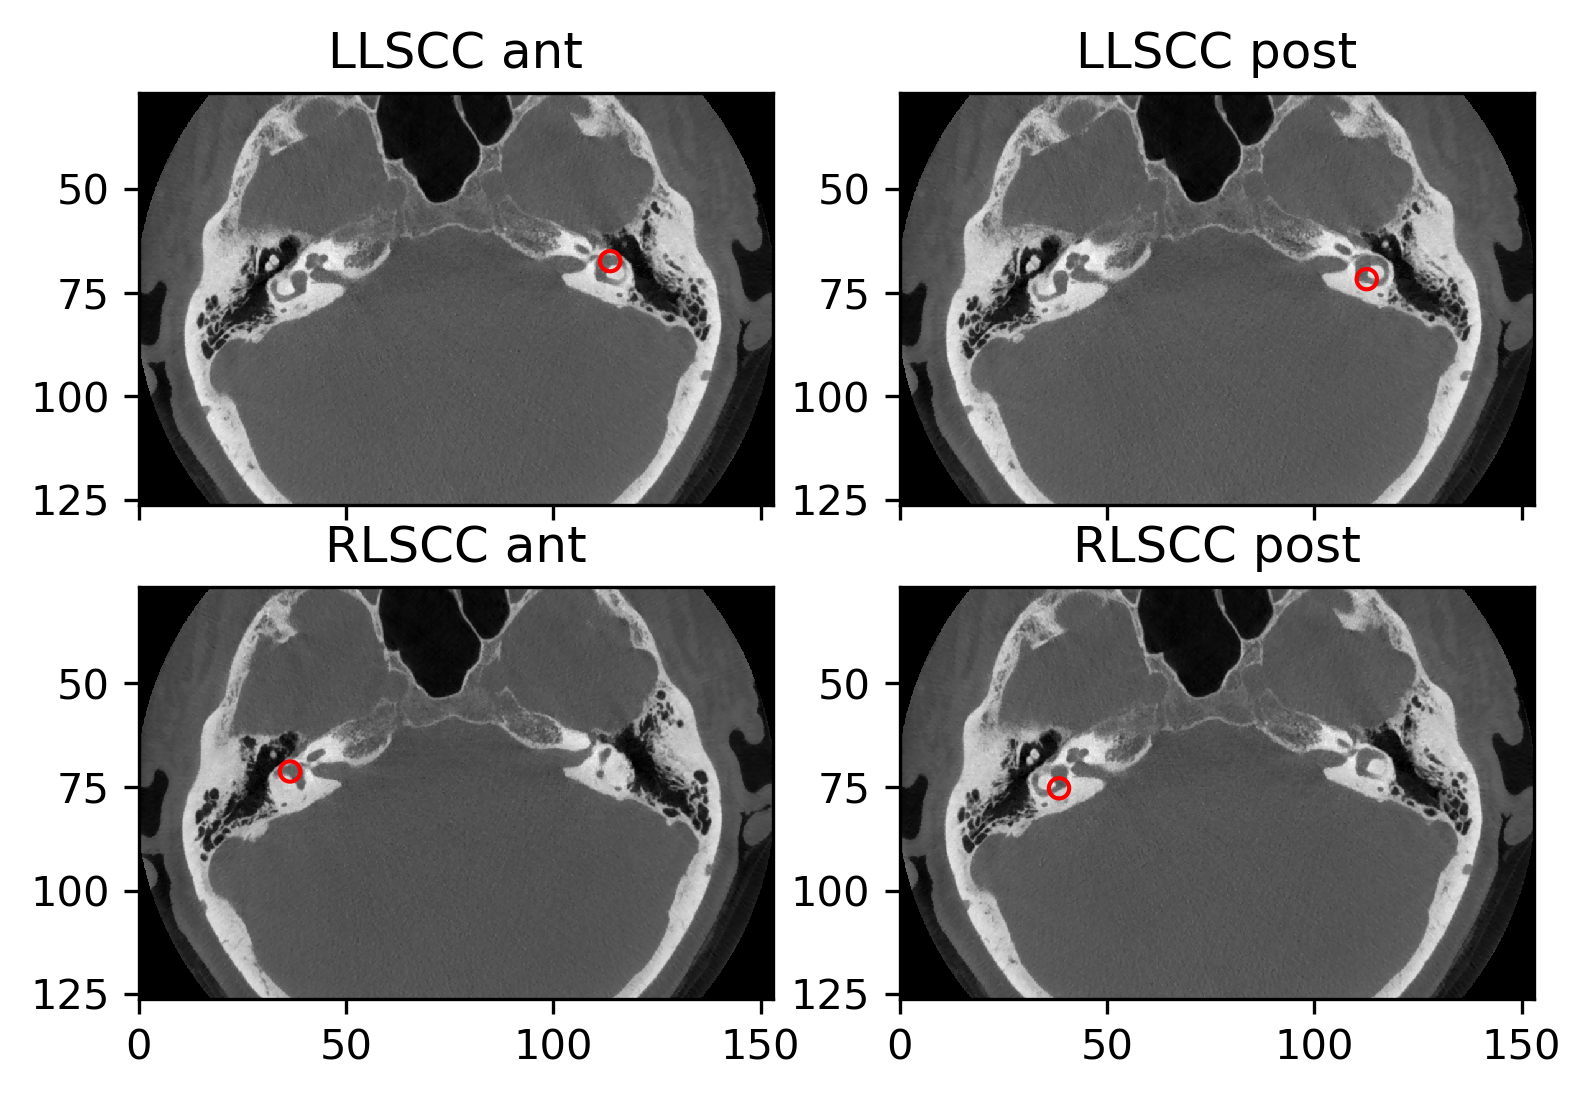

In [24]:
show_pts(AH_volume, AH_pts, AH_pixel_space)

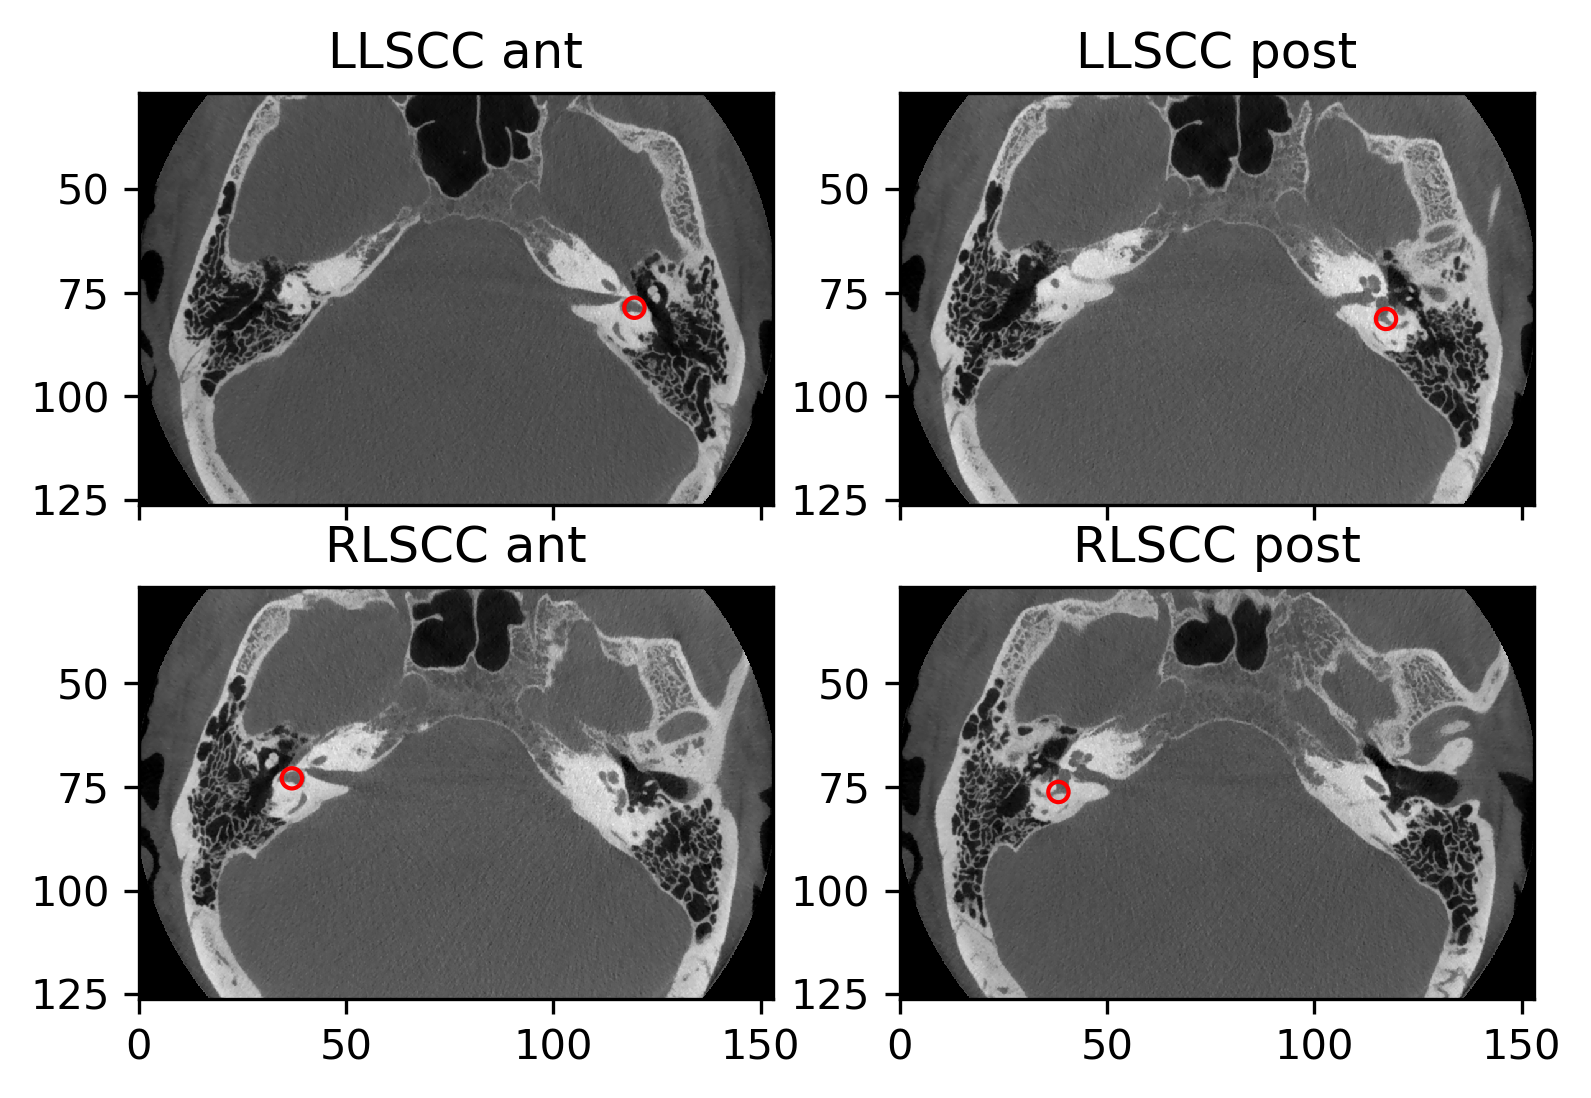

In [25]:
dicom_AZ_CT_path = '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post/AZ Pre'
AZ_volume, AZ_pixel_space, AZ_dicom_ref = load_dicom_data("AZ", dicom_AZ_CT_path)

AZ_pts = np.copy(roi_CT.loc['AZ'].Median.loc[['LLSCC ant', 'LLSCC post', 'RLSCC ant', 'RLSCC post']].values)
show_pts(AZ_volume, AZ_pts, AZ_pixel_space)

## Augment DICOM data: Rotate and Translate

In [26]:
import numpy as np
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians (Euler-Rodrigues formula).
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [27]:
m1 = rotation_matrix([1, 0, 0], np.pi/4)
print(m1)
m2 = rotation_matrix([1, 0, 0], -np.pi/4)
print(m2)

[[ 1.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678]
 [ 0.          0.70710678  0.70710678]]
[[ 1.          0.          0.        ]
 [ 0.          0.70710678  0.70710678]
 [ 0.         -0.70710678  0.70710678]]


In [28]:
npos = np.dot(m1, [0.15,0.15,0.15])
print(npos)
opos = np.dot(m2, npos)
print(opos)

[ 1.50000000e-01 -1.38777878e-17  2.12132034e-01]
[0.15 0.15 0.15]


In [29]:
from IPython.display import display, clear_output

def refresh_display(str):
    clear_output(wait=True)
    display(str)

In [62]:
def rotate_3d_volume(volume, points, origin, axis, theta):
    """
    input:
        volume -- shape (row, column, slice), it stores the pixel value; RHS/LHS
        points -- some points in the original volume: [[row,column,slice],[r,c,s]...]
        rot_origin -- the origin point for the rotation process, should be in the same coordinate format as volume
        axis -- rotation axis
        theta -- rotation angle, counterclockwise on the specific axis
    output:
        rotated_volume -- shape (row, column, slice), consistent with the original volume coordinate format
        rotated_points -- the index of the points in the rotated volume
        mask -- The cover of the model in the rotated volume
    """
    # calculate rotate matrix and invert rotate matrix
    rot_matrix = rotation_matrix(axis, theta)
    inv_rot_matrix = rotation_matrix(axis, -theta)
    # get the min pixel value as the filler value
    fill_value = np.min(volume)
    # calculate the border of the rotated volume, the border is represented by 8 vertexes' positions
    original_vertexes = [ (row,column,slice) for row in [0, 1] for column in [0, 1] for slice in [0, 1] ]
    original_vertexes = np.multiply(original_vertexes, np.asarray(volume.shape)-1) # 0-indexing
    original_vertexes = original_vertexes - np.ones(original_vertexes.shape)*origin # positions in origin coordinate system
    rotated_vertexes = np.dot(rot_matrix, original_vertexes.T).T
    # calculate the new volume shape to store the rotated model from the same perspective
    min_border_point = np.floor(np.amin(rotated_vertexes, axis=0)).astype(int)
    max_border_point = np.ceil(np.amax(rotated_vertexes, axis=0)).astype(int)
    rotated_volume_shape = max_border_point - min_border_point + 1 # look at the model from the same perspective
    rotated_volume = np.ones(rotated_volume_shape) * fill_value
    # mask for the model
    mask = np.zeros(rotated_volume_shape)

    # calculate the positions of the given points in the rotated volume (not integer, the position's unit is the new volume's index)
    rotated_points = np.dot(rot_matrix, (points - np.ones(points.shape)*origin).T).T # position in the original volume index system
    round_rotated_points = np.round(rotated_points).astype(int) # round index position in the original volume index
    rotated_points = round_rotated_points - np.ones(round_rotated_points.shape)*min_border_point # relative positions in the new volume
    rotated_points = rotated_points.astype(int)
    # identify the mate pixel value for the rotated volume from the original volume
    volume_shape = volume.shape
    for row in range(min_border_point[0], max_border_point[0]):
        refresh_display("start row: " + str(row) + " / " + str(max_border_point[0]))
        for col in range(min_border_point[1], max_border_point[1]):
            for slc in range(min_border_point[2], max_border_point[2]):
            #for slc in round_rotated_points[:,2]:
                # test only
                # volume[tuple(mate_index)] = 1
                mate_position = np.dot(inv_rot_matrix, [row, col, slc])
                mate_index = mate_position + origin
                mate_index = np.round(mate_index).astype(int)
                # check limit
                if all(mate_index>=0) and mate_index[0]<volume_shape[0] and mate_index[1]<volume_shape[1] and mate_index[2]<volume_shape[2]:
                    # assign pixel value
                    rotated_volume_index = [row, col, slc] - min_border_point
                    rotated_volume[rotated_volume_index[0]][rotated_volume_index[1]][rotated_volume_index[2]] = \
                        volume[mate_index[0], mate_index[1], mate_index[2]]
                    mask[rotated_volume_index[0]][rotated_volume_index[1]][rotated_volume_index[2]] = 1

    return  rotated_volume, mask, rotated_points

In [87]:
def rotate_3d_volume_speedup(volume, points, origin, axis, theta, partially=False):
    """
    input:
        volume -- shape (row, column, slice), it stores the pixel value; RHS/LHS
        points -- some points in the original volume: [[row,column,slice],[r,c,s]...]
        rot_origin -- the origin point for the rotation process, should be in the same coordinate format as volume
        axis -- rotation axis
        theta -- rotation angle, counterclockwise on the specific axis
    output:
        rotated_volume -- shape (row, column, slice), consistent with the original volume coordinate format
        rotated_points -- the index of the points in the rotated volume
        mask -- The cover of the model in the rotated volume
    """
    # calculate rotate matrix and invert rotate matrix
    rot_matrix = rotation_matrix(axis, theta)
    inv_rot_matrix = rotation_matrix(axis, -theta)
    # get the min pixel value as the filler value
    fill_value = np.min(volume)
    # calculate the border of the rotated volume, the border is represented by 8 vertexes' positions
    original_vertexes = [ (row,column,slice) for row in [0, 1] for column in [0, 1] for slice in [0, 1] ]
    original_vertexes = np.multiply(original_vertexes, np.asarray(volume.shape)-1) # 0-indexing
    original_vertexes = original_vertexes - np.ones(original_vertexes.shape)*origin # positions in origin coordinate system
    rotated_vertexes = np.dot(rot_matrix, original_vertexes.T).T
    # calculate the new volume shape to store the rotated model from the same perspective
    min_border_point = np.floor(np.amin(rotated_vertexes, axis=0)).astype(int)
    max_border_point = np.ceil(np.amax(rotated_vertexes, axis=0)).astype(int)
    rotated_volume_shape = max_border_point - min_border_point # look at the model from the same perspective
    # mask for the model
    mask = np.zeros(rotated_volume_shape)

    # calculate the positions of the given points in the rotated volume (not integer, the position's unit is the new volume's index)
    rotated_points = np.dot(rot_matrix, (points - np.ones(points.shape)*origin).T).T # position in the original volume index system
    round_rotated_points = np.round(rotated_points).astype(int) # round index position in the original volume index
    rotated_points = round_rotated_points - np.ones(round_rotated_points.shape)*min_border_point # relative positions in the new volume
    rotated_points = rotated_points.astype(int)
    ## for test
    slc_range = range(min_border_point[2], max_border_point[2])
    if partially:
        rotated_points[:, 2] = np.asarray([0,1,2,3])
        slc_range = round_rotated_points[:,2]
    # identify the mate pixel value for the rotated volume from the original volume
    # print("start locate original pixel value's index")
    rotated_volume = []
    volume_shape = volume.shape
    # original_positions = np.arange(volume_shape[1]*volume_shape[2]*3).reshape(volume_shape[1] * volume_shape[2],3)
    for row in range(min_border_point[0], max_border_point[0]):
        refresh_display("start row: " + str(row) + " / " + str(max_border_point[0]))
        rotated_positions = np.asarray([[row, col, slc] \
                         # for row in range(min_border_point[0], max_border_point[0]) \
                         for col in range(min_border_point[1], max_border_point[1]) \
                         for slc in slc_range]).T
        original_positions = np.dot(inv_rot_matrix, rotated_positions).T
        original_indexes = original_positions + np.ones(original_positions.shape) * origin
        original_indexes = np.round(original_indexes).astype(int)
        # rotated_volume = [volume[tuple(mate_index)] \
        #                                         if all(mate_index>=0) and mate_index[0]<volume_shape[0] and mate_index[1]<volume_shape[1] and mate_index[2]<volume_shape[2] \
        #                                         else fill_value for mate_index in original_indexes]
                                               #else fill_value for mate_index in original_indexes]).reshape(rotated_volume_shape[0],rotated_volume_shape[1], 4)
        # test only
        mate_index = original_indexes[0]
        if all(mate_index>=0) and mate_index[0]<volume_shape[0] and mate_index[1]<volume_shape[1] and mate_index[2]<volume_shape[2]:
            rotated_volume = rotated_volume + [1]

    if partially:
        rotated_volume = numpy.asarray(rotated_volume).reshape(rotated_volume_shape[0], rotated_volume_shape[1], 4)
    else:
        rotated_volume = numpy.asarray(rotated_volume).reshape(rotated_volume_shape)

    return  rotated_volume, mask, rotated_points

In [32]:
def translate_3d_volume(volume, points):
    """
    Randomly transfer the volume
    """
    # get random translation
    max_trans = 5
    rand_trans = np.random.rand(1, 3)
    trans_vec = np.round(2 * max_trans * rand_trans - max_trans)

    # construct translated volume
    translated_volume_shape = np.asarray(volume.shape) + np.abs(trans_vec)
    translated_volume = np.ones(translated_volume_shape.astype(int).squeeze()) * np.amin(volume)

    # get start and end positions in the translated volume, and point locations
    translated_points = np.copy(points)
    start_position = np.asarray([[0, 0, 0]])
    for idx in np.arange(3):
        if trans_vec[:, idx] > 0:
            start_position[:, idx] = start_position[:, idx] + trans_vec[:, idx]
            translated_points[:, idx] = translated_points[:, idx] + trans_vec[:, idx]
    end_position = start_position + np.asarray(volume.shape)

    # calculate translated volume
    start_position = start_position.squeeze()
    end_position = end_position.squeeze()
    translated_volume[start_position[0]:end_position[0], start_position[1]:end_position[1], start_position[2]:end_position[2]] = volume

    print("Translation vector: ", trans_vec)
    return translated_volume, translated_points




In [63]:
def augment_3d_volume(volume, pts, partically=False):
    # max rotation angle: 15 Degrees; change to Radian
    max_rot_angle = 30 * math.pi / 180
    # random rotation angle: -max to +max
    rand_angle = 2 * np.random.rand() * max_rot_angle - max_rot_angle
    # random rotation axis
    rot_axis = np.random.rand(3, )
    # The position matrix_(4*3) of LLSCC ant, LLSCC post, RLSCC an and RLSCC post: [x, y, z] --- [column, row, slice] is LHS
    pts_cp = np.copy(pts)
    pts_cp[:, [0, 1]] = pts_cp[:, [1, 0]] # change LHS to RHS, make it consistent with ArrayDicom
    # Set the origin to the median point of these pts
    origin_pts = np.mean(pts_cp, axis=0)
    #
    # the ArrayDicom is RHS
    # rotate the volume
    #rotated_volume, mask, rotated_pts = rotate_3d_volume(ArrayDicom, pts, origin_pts, [1,0,0], np.pi)
    # rotated_volume, mask, rotated_pts = rotate_3d_volume(volume, pts_cp, origin_pts, rot_axis, rand_angle)
    rotated_volume, mask, rotated_pts = rotate_3d_volume_speedup(volume, pts_cp, origin_pts, rot_axis, rand_angle, partically)

    # translate the volume
    translated_volume, translated_pts = translate_3d_volume(rotated_volume, rotated_pts)
    # change back to RHS
    translated_pts[:, [0,1]] = translated_pts[:, [1,0]]

    print("rot_axis: ", rot_axis)
    print("rot_angle: ", np.round(rand_angle*180/math.pi))

    return translated_volume, mask, translated_pts

In [88]:
start_time = time.time()
AH_augmented_volume, AH_mask, AH_augmented_pts = augment_3d_volume(AH_volume, AH_pts)
end_time = time.time()
duration = np.round(end_time - start_time)
print("The augmentation takes: ", duration)

'start row: -560 / 656'

KeyboardInterrupt: 

In [ ]:
print(AH_augmented_volume.shape)
print(AH_augmented_pts)

In [ ]:
print(AH_augmented_volume.shape)
print(AH_augmented_pts)

show_pts(AH_augmented_volume, AH_augmented_pts, [0.15, 0.15, 0.15])

In [ ]:
from scipy.ndimage import zoom
import numpy as np

def rescale_3d_volume(volume, points, target_size=(170, 170, 30)):
    zoom_scale = np.divide(target_size, volume.shape)
    print("zoom scale is: ", zoom_scale)

    zoomed_volume = zoom(AH_volume, zoom_scale)
    zoomed_points = np.copy(points)
    zoomed_points[:, [0, 1]] = zoomed_points[:, [1, 0]]
    zoomed_points = np.round(np.multiply(zoomed_points, zoom_scale).astype(int))
    zoomed_points[:, [0, 1]] = zoomed_points[:, [1, 0]]

    return zoomed_volume, zoomed_points

## load data from Matlab's .mat file

In [109]:
import numpy as np
import h5py

file = h5py.File("/Volumes/ExternalDis/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/AH_aug_3.mat", 'r')
load_mat_vol = file.get('augVol')
load_mat_pts = file.get('augPts')
load_mat_vol = np.array(load_mat_vol)
load_mat_pts = np.array(load_mat_pts)

In [114]:
print(file.keys())
file.close()

<KeysViewHDF5 ['augPts', 'augVol']>


In [111]:
print(load_mat_pts)
print(load_mat_vol.shape)

[[830.8018363  829.86490698 332.396593   350.93666372]
 [523.66092873 553.00756852 646.07497639 669.25652636]
 [343.51339032 337.86565659 292.94646056 285.67449254]]
(545, 1229, 1229)


In [112]:
load_mat_pts = np.round(load_mat_pts.T).astype(int)
print(load_mat_pts)
load_mat_vol = load_mat_vol.T

[[831 524 344]
 [830 553 338]
 [332 646 293]
 [351 669 286]]


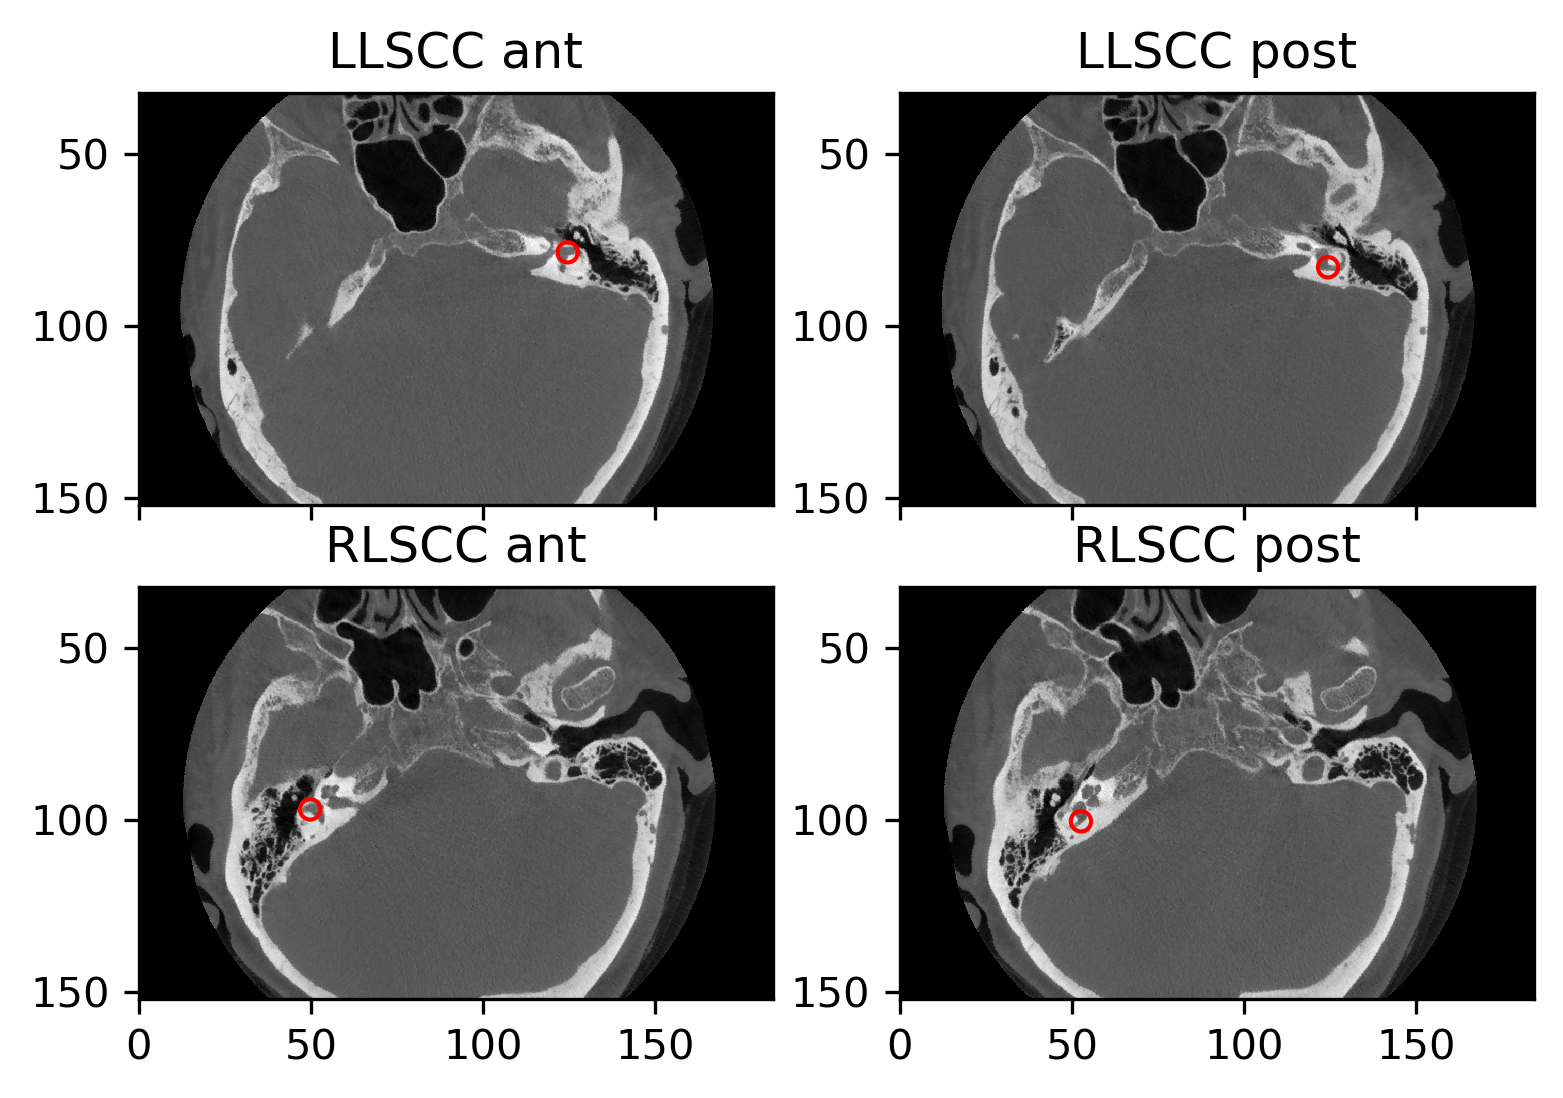

In [113]:
show_pts(load_mat_vol, load_mat_pts, [0.15, 0.15, 0.15])

In [131]:
file_vol = h5py.File("/Volumes/ExternalDis/PhD/Project/Date/augmentation_from_matlab/Test/Input/AH_17017030_AugVol_2.mat", 'r')
file_pts = h5py.File("/Volumes/ExternalDis/PhD/Project/Date/augmentation_from_matlab/Test/Output/AH_17017030_AugPts_2.mat", 'r')
load_mat_vol = file_vol.get('rescaled_aug_vol')
load_mat_pts = file_pts.get('rescaled_aug_pts')
load_mat_vol = np.array(load_mat_vol)
load_mat_pts = np.array(load_mat_pts)

In [132]:
print(load_mat_pts)
print(load_mat_vol.shape)

[[117.80633703 117.27471139  42.14477441  44.5417828   75.34211087
   79.73776659  88.01929509  91.7725322   19.09402008  18.91224424
   19.06494856  18.58529681]]
(30, 170, 170)


In [133]:
load_mat_pts = load_mat_pts.reshape(3,4).T.astype(int)

In [134]:
load_mat_vol = load_mat_vol.T

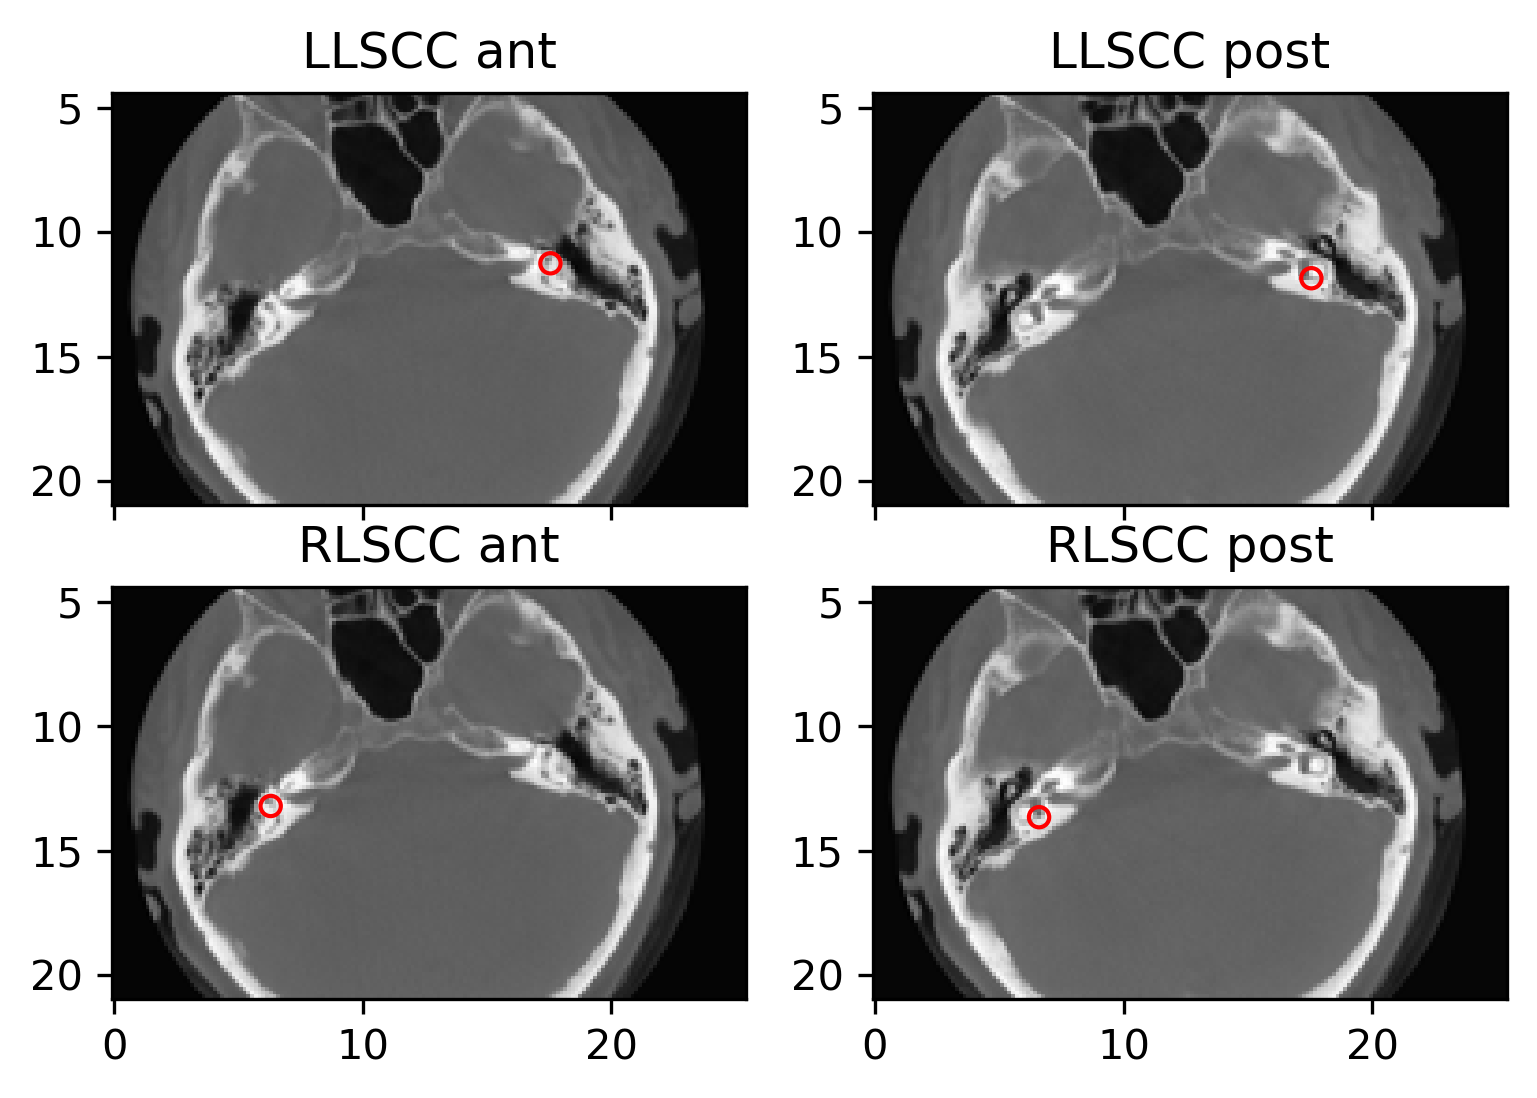

In [135]:
show_pts(load_mat_vol, load_mat_pts, [0.15, 0.15, 0.15])